### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from simple_read_ligo import read_template, read_file
import json

In [355]:
dataLocation = "./LOSC_Event_tutorial/"

#read json file for data names
with open(dataLocation+"BBH_events_v3.json") as f:
    jdata = json.load(f)

# the event data files (32s sampled at 4096 Hz, in hdf5 format, for both LIGO detectors).
# waveform templates (32s sampled at 4096 Hz, in hdf5 format, for both plus and cross polarizations).
#data from LIGO Hanford Observatory (H1) and LIGO Livingston Observatory (L1) 

#our 4 event names
events = ["GW150914", "GW151226", "LVT151012", "GW170104"]

def getData(event):

    #reading the data
    fnameH=jdata[events[event]]['fn_H1']
    fnameL=jdata[events[event]]['fn_L1']

    print('reading file ',fnameH)
    H1=read_file(dataLocation+fnameH) #strain,dt,utc
    L1=read_file(dataLocation+fnameL)
    '''
    strain: data taken
    dt: (1.0*duration)/len(strain)
    utc: UTCstart - start of event in Coordinated Universal Time
    '''

    #reading the template
    template_name=jdata[events[event]]['fn_template']
    template =read_template(dataLocation+template_name) #th,tl

    """
    th: Hanford template
    tl: Livingston template
    """
    
    return [H1, L1, template]

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5
0.000244140625 b'2015-09-14T09:50:30'



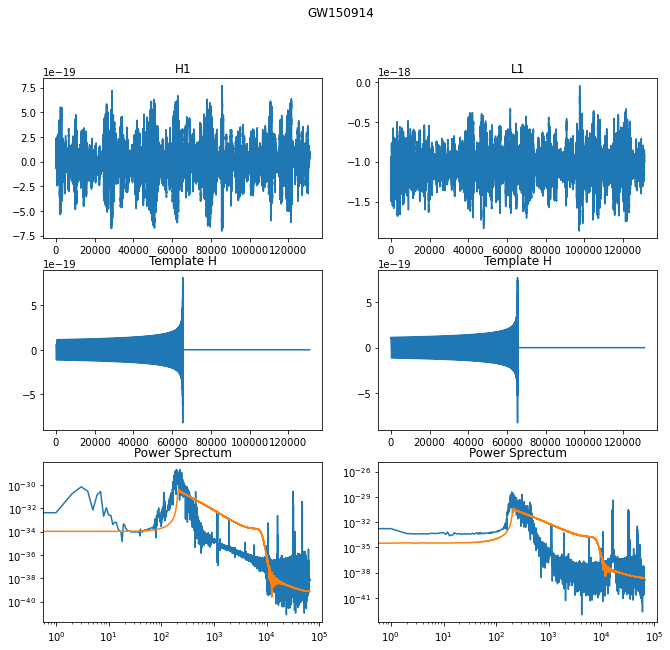

In [356]:
H1, L1, template = getData(0)
strain_H,dt_H,utc_H = H1
strain_L,dt_L,utc_L = L1
th,tl = template

fig, ax = plt.subplots(3, 2, figsize=(11,10))
axs = ax.flatten()

fig.suptitle(events[0])

axs[0].set_title("H1")
axs[0].plot(strain_H)
axs[1].set_title("L1")
axs[1].plot(strain_L)

print(dt_H, utc_H)

axs[2].set_title("Template H")
axs[2].plot(th)

axs[3].set_title("Template L")
axs[3].plot(tl)

axs[4].set_title("Power Sprectum")
axs[4].loglog(np.abs(np.fft.rfft(strain_H)**2))
axs[4].loglog(np.abs(np.fft.rfft(th)**2))

axs[5].set_title("Power Sprectum")
axs[5].loglog(np.abs(np.fft.rfft(strain_L)**2))
axs[5].loglog(np.abs(np.fft.rfft(tl)**2))

print()

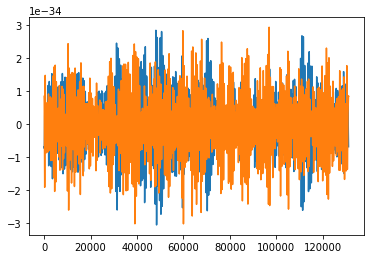

In [358]:
corr = matchFilter(strain_H, th)
plt.plot(corr)
corr = matchFilter(strain_L, tl)
plt.plot(corr)

#### a) 
Come up with a noise model for Livingston and Hanford separately. Describe in comments how you go about doing this. 
- something about how you smooth the power spectrum 
- how you deal with lines (if at all). 

Please also explain how you window the data (you may want to use a window that has an extended flat period near the center to avoid tapering the data/template where the signal is not small). 

In [362]:
def window(data, n=0, Type="cos"):
       
    if Type=="cos": #just a simple cosine window, but tapers alot of data
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        
    elif Type=="flatcos": #cosine but in center is a boxcar to avoid making signal smaller - get weird spikes from this
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        win[n:len(data)-n]=np.max(win)
#         win=win/np.sum(n) #normalize

# Tukey window, also known as the cosine-tapered window - much nicer form
    elif Type=="Tukey":
        a=n
        N = int(len(data))
        L = N+1
        n = np.arange(N)
        win = 0.5*(1-np.cos(2*np.pi*n/(a*L)))
#         print(int(a*L/2), int(N/2))
        win[int(a*L/2):int(N/2)] = 1
        win[int(N/2):] = win[::-1][int(N/2):]
        
#     plt.plot(win)
#     plt.show()
    
    windowedData = win*data
    return windowedData


In [319]:
def noise(data, Type="square"): #just for now - later use fixed PS of data
    FT = np.fft.rfft(data)
    
    if Type=="square": #really the PS
        N=np.abs(FT)**2
        
    return N #noiseData

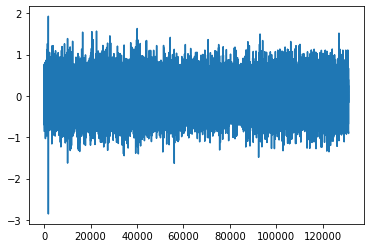

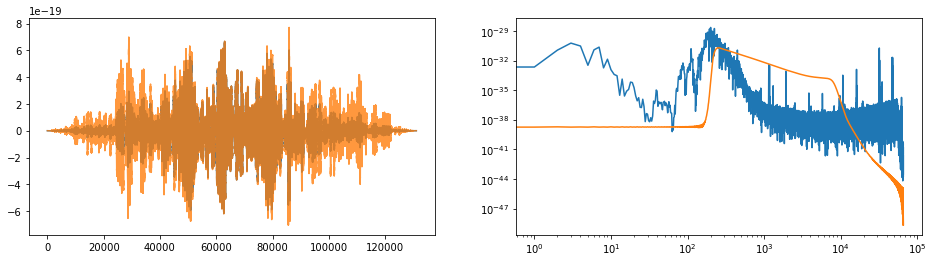

In [360]:
#what we did in class
# H_noise = noise(window(strain_H))
# signal_win = window(th)
# print(len(signal_win), len(H_noise))
# H_noise = smooth(H_noise, 5)

# mf = matchFilter(window(strain_H), signal_win, H_noise)

# plt.plot(mf)
# plt.show()

alpha=0.5
strain_H_win = window(strain_H, n=alpha, Type="Tukey")

signal_win = window(th, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

#really should be in next section
H_noise = noise(strain_H_win)
mf = matchFilter(strain_H_win, signal_win, H_noise)
plt.plot(mf)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].plot(window(strain_H))
ax[0].plot(window(strain_H, n=alpha, Type="Tukey"), alpha=0.8)

ax[1].loglog(np.abs(np.fft.rfft(strain_H_win)**2))
ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2))
plt.show()

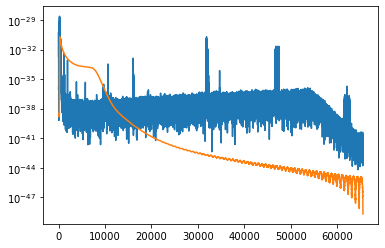

In [314]:
plt.semilogy(np.abs(np.fft.rfft(strain_H_win)**2))
plt.semilogy(np.abs(np.fft.rfft(signal_win)**2))
plt.show()

In [407]:
def smooth(data, num, Type="boxcar"):
    FT = np.fft.rfft(data)
    if Type=="boxcar":
        sm=np.zeros(len(data))
        #set center to 1
        sm[:num]=1
        sm[-num+1:]=1
        sm=sm/np.sum(sm) #normalize
        
    if Type=="gaussian":    
        N = len(data)
        x = np.linspace(-1, 1, len(data))

        #gaussian function
        std = num
        gaussian = np.exp(-x**2 / (2*std**2))
        gaussian2 = np.exp(-x**2 / (2*std**2))
        gaussian[:int(N/2)] = gaussian[int(N/2)+1:]
        gaussian[int(N/2):] = gaussian2[:int(N/2)+1]
        
        sm=gaussian/np.sum(gaussian) #normalize?
        
    print(sum(sm))
    print(sm)
    plt.plot(sm)
    plt.show()
    
    smFT = np.fft.rfft(sm)
    plt.plot(smFT)
    plt.show()

    smoothedData = np.fft.irfft(smFT*FT, len(data)) # to make sure irfft is right length
    return smoothedData

1.0000000000000009
[1.53603502e-05 1.53603502e-05 1.53603502e-05 ... 1.53603502e-05
 1.53603502e-05 1.53603502e-05]


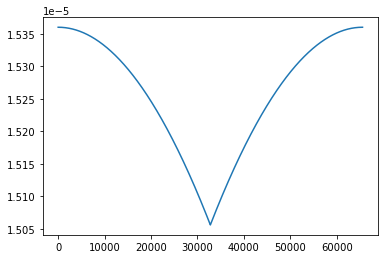

C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


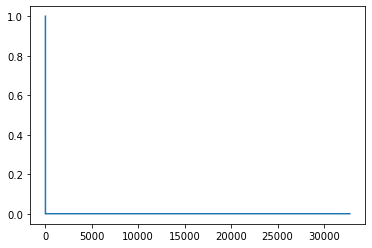

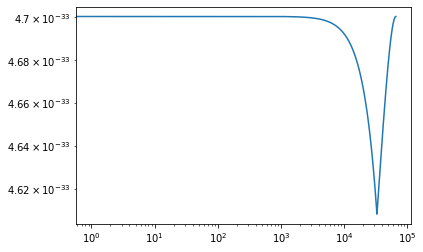

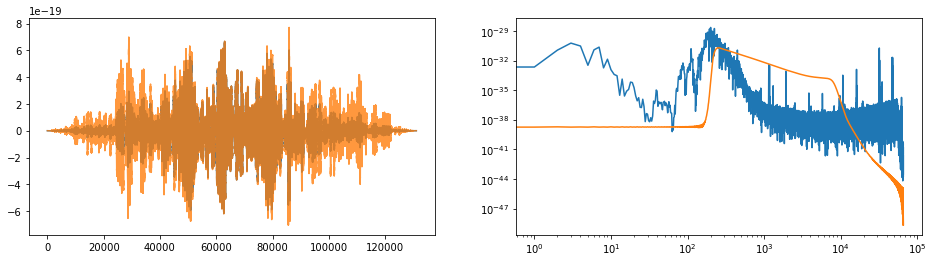

In [413]:
alpha=0.5
strain_H_win = window(strain_H, n=alpha, Type="Tukey")

H_noise = noise(strain_H_win)
signal_win = window(th, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

# gaussian - nope
H_noise = smooth(H_noise, 5, 'gaussian')
plt.loglog(H_noise)

# mf = matchFilter(strain_H_win, signal_win, H_noise)
# plt.plot(mf)
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].plot(window(strain_H))
ax[0].plot(window(strain_H, n=alpha, Type="Tukey"), alpha=0.8)

ax[1].loglog(np.abs(np.fft.rfft(strain_H_win)**2))
ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2))
plt.show()

0.999999999999993
[0.00060874 0.00060873 0.00060873 ... 0.00060873 0.00060874 0.00060874]


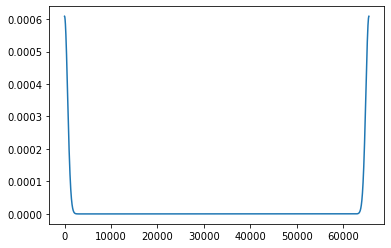

C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


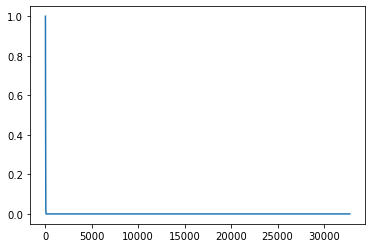

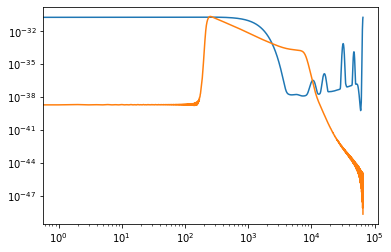

In [411]:
# https://matthew-brett.github.io/teaching/smoothing_as_convolution.html

ps_smooth = smooth(np.abs(np.fft.rfft(strain_H_win)**2), 0.02, 'gaussian')

#really didn't work
plt.loglog(ps_smooth)
plt.loglog(np.abs(np.fft.rfft(signal_win)**2))
plt.show()

b) Use that noise model to search the four sets of events using a matched
filter. The mapping between data and templates can be found in the file BBH events v3.json, included in the zipfile. 

In [197]:
#matched_filt_h=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(th_white)))

def matchFilter(data, template, N=0):
    if isinstance(N, int):
        mf = np.fft.irfft(np.fft.rfft(data)*np.conj(np.fft.rfft(template)))
    else:
        mf = np.fft.irfft((np.fft.rfft(data)/N)*np.conj(np.fft.rfft(template)))
    return mf

In [412]:
# whitening - use N^-1/2 A and N^-1/2 d for the template and strain for matched filter.

N = np.abs(np.fft.rfft(strain_H_win)**2)
print(len(N), len(strain_H_win))

mf = matchFilter((N**-0.5) * strain_H_win, (N**-0.5) *signal_win)
plt.plot(mf)
plt.show()

65537 131072


ValueError: operands could not be broadcast together with shapes (65537,) (131072,) 

c) Estimate a noise for each event, and from the output of the matched
filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Livingston + Hanford events. 

d) Compare the signal-to-noise you get from the scatter in the matched
filter to the analytic signal-to-noise you expect from your noise model. How close are they? If they disagree, can you explain why? 

e) From the template and noise model, find the frequency from each event
where half the weight comes from above that frequency and half below. 

f) How well can you localize the time of arrival (the horizontal shift of
your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?